<a href="https://colab.research.google.com/github/VhinyMombo/Boltzmann-Machine/blob/main/Ising_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model Ising

In [1]:
#%%writefile -a IsingModel.py
from gzip import READ
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.datasets import mnist

class IsingModel():
  def __init__(self,n,p,beta,nb_cycle,prob = 0.5):
    self._n = 50
    self._p = p
    self._proba = prob
    self.nb_cycle = nb_cycle
    self.beta = beta
    

  def __get_neighbours2(self, i,j):
    u = 1 if i+1 > self._n-1 else i+1
    a = self._n-1 if i-1 < 0 else i-1
    l = self._p-1 if j-1 < 0 else j-1
    r = 1 if j+1 > self._p-1 else j+1

    neighoors_coord = np.array([u,l,u,r,a,l,a,r]).reshape([4,2])
    return neighoors_coord

  def  get_params(self):
    
    return {'n' : self._n,
            'p' : self._p,
            'proba' : self._proba,
            'beta' : self.beta,
            'nb_cycle' : self.nb_cycle}

  def __update(self, i,j,mat2):
    sum_N_index= sum([mat2[k[0],k[1]] for k in self.__get_neighbours2(i,j)])

    pX_ij_cond_Nij  = 1/(1+np.exp(-2*self.beta * sum_N_index))
    
    mat2[i,j] = 2 * np.random.binomial(1,pX_ij_cond_Nij,1)-1
    return mat2.reshape(self._n,self._p).T

  def __call__(self):
    cycle = 1
    mat  = ((2 * np.random.binomial(1,self._proba,self._n * self._p)-1)
    .reshape([self._n, self._p]))
    mat2 = mat.copy()

    for cycle in tqdm(range(self.nb_cycle), desc ="epochs"):
      cycle+=1
      #print(cycle)
      walk_order = random.sample(list(range(self._n*self._p)),self._n*self._p)
      for i in range(self._n):
        for j in range(self._p):
          mat2 = self.__update(i,j,mat2)    
    return mat2



epochs: 100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


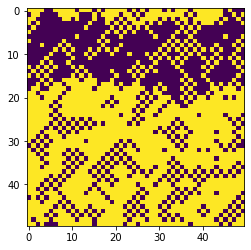

In [2]:
#%%writefile -a main.py
n = 50
p =  50
prob = 0.5
beta = 10
nb_cycle = 100
model = IsingModel(n,p,beta, nb_cycle,prob)
plt.imshow(model())
plt.show()

In [3]:
model.get_params()

{'beta': 10, 'n': 50, 'nb_cycle': 100, 'p': 50, 'proba': 0.5}

In [4]:
n = 1
p = 0.5
s = 2*np.random.binomial(1, p, 1)-1
s

array([1])

In [172]:
#%%writefile -a Boltzmann.py


def min_max_scl(v):
  return (v-v.min())/(v.max()-v.min())
def scale(v):
  return (v- v.mean())/v.std()


class BoltzmannModel(IsingModel):
  def __init__(self,n,p,beta, nb_cycle,prob,input_size, n_hidden_unit, eps = 1e-3):
    super().__init__(n,p,beta,nb_cycle,prob)
    self._input_size = input_size
    self._n_hidden_unit = n_hidden_unit
    self._W = np.random.random([n_hidden_unit,input_size])
    self._eps = eps
    self._c = np.random.random([1,n_hidden_unit])
    self._b = np.random.random([1,input_size])
    

  def  get_params(self):
    
    return {'n' : self._n,
            'p' : self._p,
            'proba' : self._proba,
            'beta' : self.beta,
            'nb_cycle' : self.nb_cycle,
            'input_size' : self._input_size,
            'n_hidden_unit' : self._n_hidden_unit,
            'eps' : self._eps}

  def __simul(self, v):
    cycle = 1
    mat  = ((2 * np.random.binomial(1,self._proba,len(x))-1)
    .reshape([self._n, self._p]))
    mat2 = mat.copy()

    while(cycle <= self.nb_cycle):
      cycle+=1
      #print(cycle)
      #walk_order = random.sample(list(range(self._n*self._p)),self._n*self._p)
      for i in range(self._n):
        for j in range(self._p):
          mat2 = self.__update(i,j,mat2)    
    return mat2

  def _forward(self,x):
    x = x.flatten()[:, None].T
    #h = np.random.random(self._n_hidden_unit)
    activation  = scale(self._c+ x.dot(self._W.T))
    p_h_v = 1/(1+np.exp(-activation)).ravel()
    h = np.array([np.random.binomial(1,p_h_v[i],1)[0] for i in range(len(p_h_v))])
    return h[:, None].T
  
  def Forward(self,x):
    x = x.flatten()[:, None].T
    #h = np.random.random(self._n_hidden_unit)
    activation  = scale(self._c+ x.dot(self._W.T))
    p_h_v = 1/(1+np.exp(-activation)).ravel()
    h = np.array([np.random.binomial(1,p_h_v[i],1)[0] for i in range(len(p_h_v))])
    return h[:, None].T

  def _backward(self, h):
    activation= scale(self._b + h.dot(self._W))
    p_v_h = 1/(1+np.exp(-activation)).ravel()
    v = np.array([np.random.binomial(1,p_v_h[i],1)[0] for i in range(len(p_v_h))])
    return v[:, None].T

  def get_w(self):
    return(self._W)

  def CD_k(self, data, k = 10):
    h = np.zeros([len(data), self._n_hidden_unit])
    DW = np.zeros([self._n_hidden_unit, self._input_size])
    Db = np.zeros([1,self._input_size])
    Dc = np.zeros([1,self._n_hidden_unit])
    v = np.zeros( [k, self._input_size])
    for s in tqdm(range(len(data))):
      v[0,] = data[s].flatten()
      vt = v[0,]
      for t in range(k-1):
        h[t,] = self._forward(vt)
        v[t+1,] = self._backward(h[t,])

      for i in range(self._n_hidden_unit):
        for j in range(self._input_size):
          a1 = scale(self._c+ v[0,].dot(self._W.T))
          a2 = scale(self._c+ v[k-1,].dot(self._W.T))
          DW[i,j] +=  (1/(1+np.exp(-a1)))[0,i]*v[0,j] - (1/(1+np.exp(-a1)))[0,i]*v[k-1,j]
          Db[0,j]+= v[0,j] - v[k-1,j]
          Dc[0,i]+= a1[0,i] - a2[0,i]
      self._W+=DW
      #print(DW.shape)
      print(np.linalg.norm(DW))
      self._b+=Db
      self._c+=Dc

  def _update_w(self, v,h,v2,h2):
    W = h.T*v#np.array([list(i*h) for i in v])
    W2 = (h2.T*v2)#np.array([list(i*h2) for i in v2])
    DW = self._eps * (W-W2)
    self._W+=DW
    self._b += v-v2
    self._c =  v.dot(self._W.T)- v2.dot(self._W.T)


  def forward(self,v):
    v = v.flatten()
    v = (v-v.mean())/v.std()
    for cycle in tqdm(range(self.nb_cycle), desc ="epochs"):
      h = self._forward(v)
      #print(np.linalg.norm(self._W))
      v_prime = self._backward(h)
      h_prime = self._forward(v_prime)
      self._update_w(v,h,v_prime,h_prime)
    return self._W

  def CD_1(self,v):
    v = v[:,None].T

    mu = 1*(np.array([self._forward(v) for _ in range(100)]).mean(axis = 0) >  0.5)
    print(mu)
    h = self._forward(v)
    v_p = self._backward(h)
    print(v*h)
    mu_p = 1*(np.array([self._forward(v_p) for _ in range(100)]).mean(axis = 0) >  0.5)
    Dw = v.dot(mu)-v_p.dot(mu_p)
    #return Dw


  
  def forward2(self,v):
    v = min_max_scl(v)
    for cycle in tqdm(range(self.nb_cycle), desc ="epochs"):
      wi = self._W
      self._CD_k(v, k = 20)
    return self._W


In [4]:
s = np.random.random([2,2])
print(s)
s[1,] = [0,0]
print(s)

[[0.44180715 0.38564293]
 [0.58013256 0.94684633]]
[[0.44180715 0.38564293]
 [0.         0.        ]]


In [68]:
w = np.random.random([2,5]) # é
x = (np.random.binomial(1,0.5,[1,5]))
bias = np.random.random([1,2])

prob = 1/(1+np.exp(-(bias + x.dot(w.T)))).ravel()
#prob = prob.ravel()
h =  np.array([np.random.binomial(1,prob[i],1)[0] for i in range(len(prob))])[:, None].T
#print(x.shape)
#print(f'x = {bias.shape}')
W1 =(h.T*x)
print(w-W1+0.6)
#print(f'w = {w.shape}')
#print(f'w*x = {x.dot(w.T)}')
print(f'proba = {h}')
#print(f'h = {h}')


[[ 1.45847662  0.19198671  0.96240197  1.41909387 -0.21889251]
 [ 1.18188717  0.3044237   0.7890073   1.33242608  0.28199666]]
proba = [[1 1]]


In [26]:
np.random.binomial(1,prob[0,1],1)

array([1])

In [71]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = 1*(x_train > 128)
x_test = 1*(x_test > 128)


11501568/11490434 [==============================] - 0s 0us/step


### Matrice des poids

In [173]:
input_size = x_train[1].flatten().shape[0]
n_hidden_unit = 50
nb_cycle = 10
model2 = BoltzmannModel(n,p,beta, nb_cycle,prob,input_size, n_hidden_unit)


In [174]:
model2.CD_k(x_train[10:20])

 10%|█         | 1/10 [00:07<01:11,  7.97s/it]

75.30142434003464


 20%|██        | 2/10 [00:15<01:01,  7.69s/it]

110.82906211920334


 30%|███       | 3/10 [00:23<00:53,  7.63s/it]

146.54540868090544


 40%|████      | 4/10 [00:30<00:45,  7.59s/it]

181.0567619542721


 50%|█████     | 5/10 [00:38<00:37,  7.58s/it]

227.16490857322984


 60%|██████    | 6/10 [00:45<00:30,  7.55s/it]

265.3541504747927


 70%|███████   | 7/10 [00:53<00:23,  7.77s/it]

303.081116252978


 80%|████████  | 8/10 [01:01<00:15,  7.69s/it]

344.1977723417738


 90%|█████████ | 9/10 [01:08<00:07,  7.64s/it]

386.2958782223106


100%|██████████| 10/10 [01:16<00:00,  7.64s/it]

430.00817105726253


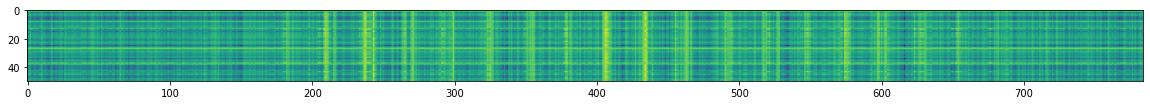

In [166]:
W0 = model2.get_w()
plt.figure(figsize=(20,50))
#model2.forward(x_train[6])
W1 = model2.get_w()
plt.imshow(W1)
plt.show()

In [167]:
model2.get_w()

array([[-10.52399084,  -9.44095896,  -7.30977445, ...,  -8.84159805,
         -7.79527258,  -9.11642409],
       [ -1.98467052,  -2.10125693,  -1.80977732, ...,  -1.87011055,
         -2.07359552,  -1.5394065 ],
       [-16.4646654 , -15.23082773, -12.15225002, ..., -16.10007888,
        -15.30163441, -14.04923934],
       ...,
       [-17.00115926, -16.31725166,  -9.85911977, ..., -12.56991918,
        -11.80086449, -14.86582993],
       [-10.00258392,  -9.15214336,  -6.14933632, ...,  -8.26433719,
         -7.61294911,  -8.52944781],
       [-10.73495234,  -9.46311332,  -8.66552767, ..., -11.70380717,
        -10.68988378,  -9.8248787 ]])

In [66]:
v = np.random.binomial(1, 0.5,10)
v = v[:,None].T
h = np.random.binomial(1, 0.5,5)
h = h[:,None].T

In [68]:
v.shape

(1, 10)

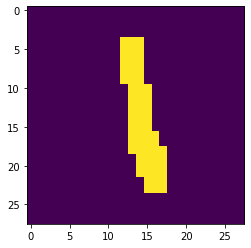

In [162]:
plt.imshow(x_train[6])

In [40]:
W = model2.forward2(x_train[:1000])

epochs:  10%|█         | 1/10 [00:08<01:19,  8.79s/it]

135.8306855776782


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: overflow encountered in exp
epochs:  20%|██        | 2/10 [00:17<01:11,  8.96s/it]

0.0


epochs:  30%|███       | 3/10 [00:27<01:03,  9.06s/it]

0.0


epochs:  40%|████      | 4/10 [00:36<00:54,  9.15s/it]

0.0


epochs:  50%|█████     | 5/10 [00:45<00:46,  9.21s/it]

0.0


epochs:  60%|██████    | 6/10 [00:55<00:37,  9.36s/it]

0.0


epochs:  70%|███████   | 7/10 [01:04<00:28,  9.34s/it]

0.0


epochs:  80%|████████  | 8/10 [01:13<00:18,  9.30s/it]

0.0


epochs:  90%|█████████ | 9/10 [01:22<00:09,  9.25s/it]

0.0


epochs: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]

0.0


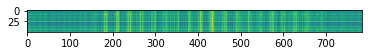

In [161]:
W1 = model2.get_w()
plt.imshow(W1)
plt.show()

In [144]:
x4 = x_train[y_train == 4]
x1 = x_train[y_train == 1]


In [145]:
X4 = np.array([model2._W.dot(min_max_scl(x4[i].flatten())) for i in range(100)])
X1 = np.array([model2._W.dot(min_max_scl(x1[i].flatten())) for i in range(100)])

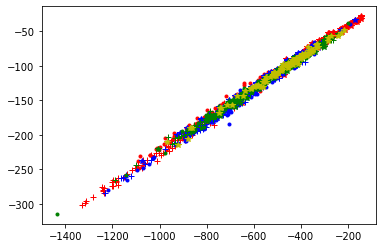

In [168]:
marker = ['r+','r*','r.',
          'b+','b*','b.',
          'g+','g*','g.', 'y*']
#plt.figure(figsize=(16,5))
for i in range(10):
  x = x_train[y_train == i]
  X = np.array([model2._W.dot(x[i].flatten()) for i in range(100)])
  plt.plot(X[:,0], X[:,1],marker[i])
plt.show()



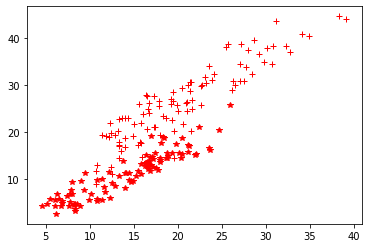

In [139]:
plt.plot(X4[:,0], X4[:,1],'r+')
plt.plot(X1[:,0], X1[:,1],'r*')


In [169]:
plt.imshow((model2._W).T.dot(np.array([X4[2,0], X4[2,1]])).reshape([28,28]))

ValueError: ignored

In [157]:
np.random.binomial(1,0.5,50)


array([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0])

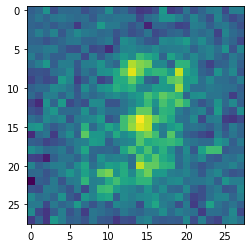

In [171]:
model2.(np.random.binomial(1,0.5,50)).reshape([28,28]))

In [31]:
import torch
class RBM():
  def __init__(self,nh,nv):
    self.W = torch.randn(nh, nv)
    self.a = torch.randn(1,nh)
    self.b = torch.randn(1,nv)

  def sample_h(self, x):
    wx = torch.mm(x, self.W.t())
    activation  = wx + self.a.expand_as(wx)
    p_h_v = torch.sigmoid(activation)
    return p_h_v, torch.bernoulli(p_h_v)

  def sample_v(self, y):
    wy = torch.mm(y, self.W.t())
    activation  = wy + self.a.expand_as(wy)
    p_v_h = torch.sigmoid(activation)
    return p_v_h, torch.bernoulli(p_v_h)
  
  def train(self,v0, vk, ph0, phk):
    self.W = torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
    self.b = torch.sum((v0-vk),0)
    self.a = torch.sum((ph0-phk),0)
    
    

In [33]:
rbm = RBM(784, 50)

In [ ]:
train_loss = 0
s =0
batch_size = 16
for i in range(len(xtrain)-batch_size, batch_size):
  vk = xtrain[i:i+batch_size,]
  v0 = xtrain[i:i+batch_size,]
  ph0, _ = rbm.sample_h(v0)
  for k in range(10):
    _,hk = rbm.sample_h(vk)
    _, vk = rbm.sample_v(hk)
    vk[v0 < 0] = v0[v0<0]
  phk, _ = rbm.sample_h(vk)
  rbm.train(v0, vk, ph0, phk)
  train_loss +=  torch.mean(torch.abs(v0[v0 > 0] - vk[v0 > 0])) 
  s+=1
   

In [42]:
img_bch = torch.tensor(x_train[1:10,])
rbm.sample_h(img_bch)

RuntimeError: ignored

In [50]:
torch.matmul(img_bch[0].flatten(),rbm.W)

RuntimeError: ignored